### Invoking Sagemaker from a Docker container.
This script is based on a modified version of this example:
https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/random_cut_forest/random_cut_forest.ipynb

Where it differs is in the two examples presented and the need to use credentials imported to the container

In [1]:
import boto3
import sagemaker
import numpy as np
from sagemaker.predictor import csv_serializer, json_deserializer
from sagemaker import RandomCutForest

In [2]:
bucket = 'yoursagemakerbuket'   # <--- specify a bucket you have access to
prefix = 'sagemaker/rcf-benchmarks'

In [3]:
import os
os.environ['AWS_DEFAULT_REGION'] = 'us-east-2'
os.environ['AWS_DEFAULT_PROFILE']= 'ec2-user'

In [5]:
import pandas as pd
import urllib.request

In [5]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100

In [6]:
#insert your sagemaker execution role below
iam = boto3.client('iam', region_name='us-east-2') 
role = iam.get_role(RoleName='AmazonSageMaker-ExecutionRole-<long number>')['Role']['Arn']

In [8]:
def shingle(data, shingle_size):
    num_data = len(data)
    shingled_data = np.zeros((num_data-shingle_size, shingle_size))
    
    for n in range(num_data - shingle_size):
        shingled_data[n] = data[n:(n+shingle_size)]
    return shingled_data

### Now fetch weather station data for skagit valley

In [36]:
data_filename = 'skajit.csv'
data_source = 'https://dbgsagemaker.s3.us-east-2.amazonaws.com/skajit.csv'
urllib.request.urlretrieve(data_source, data_filename)
skajit = pd.read_csv(data_filename, delimiter=',')

In [37]:
skajit.values[:,0]

array([37.4, 37.4, 39.2, 46.4, 51.8, 55.4, 46.4, 46.4, 46.4, 44.6, 46.4,
       48.2, 44.6, 46.4, 51.8, 53.6, 51.8, 55.4, 51.8, 48.2, 44.6, 50.0,
       55.4, 57.2, 57.2, 66.2, 60.8, 53.6, 51.8, 51.8, 48.2, 48.2, 48.2,
       48.2, 50.0, 57.2, 59.0, 57.2, 60.8, 57.2, 55.4, 57.2, 55.4, 57.2,
       55.4, 51.8, 57.2, 53.6, 55.4, 55.4, 51.8, 57.2, 57.2, 53.6, 53.6,
       51.8, 51.8, 51.8, 55.4, 51.8, 50.0, 48.2, 51.8, 53.6, 53.6, 55.4,
       57.2, 55.4, 51.8, 53.6, 53.6, 53.6, 53.6, 53.6, 53.6, 53.6, 53.6,
       53.6, 53.6, 60.8, 60.8, 60.8, 60.8, 60.8, 60.8, 66.2, 64.4, 60.8,
       64.4, 62.6, 53.6, 55.4, 53.6, 55.4, 57.2, 55.4, 57.2, 60.8, 62.6,
       60.8, 51.8, 55.4, 53.6, 53.6, 55.4, 60.8, 62.6, 59.0, 62.6, 68.0,
       68.0, 55.4, 55.4, 55.4, 53.6, 59.0, 68.0, 68.0, 62.6, 60.8, 60.8,
       59.0, 62.6, 62.6, 60.8, 59.0, 64.4, 68.0, 73.4, 73.4, 62.6, 64.4,
       60.8, 62.6, 64.4, 64.4, 66.2, 69.8, 69.8, 69.8, 73.4, 71.6, 62.6,
       60.8, 62.6, 68.0, 71.6, 75.2, 73.4, 71.6, 69

In [38]:
# single data with shingle size=48 (one day)
shingle_size = 48
prefix_shingled = 'sagemaker/randomcutforest_shingled'
skajit_data_shingled = shingle(skajit.values[:,0], shingle_size)
print(skajit_data_shingled)

[[37.4 37.4 39.2 ... 51.8 57.2 53.6]
 [37.4 39.2 46.4 ... 57.2 53.6 55.4]
 [39.2 46.4 51.8 ... 53.6 55.4 55.4]
 ...
 [51.8 50.  55.4 ... 39.2 41.  41. ]
 [50.  55.4 50.  ... 41.  41.  41. ]
 [55.4 50.  44.6 ... 41.  41.  37.4]]


In [39]:
session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix_shingled),
                      output_path='s3://{}/{}/output'.format(bucket, prefix_shingled),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(skajit_data_shingled))

2020-03-11 18:29:29 Starting - Starting the training job...
2020-03-11 18:29:31 Starting - Launching requested ML instances...
2020-03-11 18:30:29 Starting - Preparing the instances for training......
2020-03-11 18:31:18 Downloading - Downloading input data...
2020-03-11 18:31:41 Training - Downloading the training image..Docker entrypoint called with argument(s): train
/opt/amazon/lib/python2.7/site-packages/scipy/_lib/_numpy_compat.py:10: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing.nosetester import import_nose
/opt/amazon/lib/python2.7/site-packages/scipy/stats/morestats.py:12: DeprecationWarning: Importing from numpy.testing.decorators is deprecated, import from numpy.testing instead.
  from numpy.testing.decorators import setastest
[03/11/2020 18:32:18 INFO 139712752109376] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_p

In [40]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'appliation/json'
rcf_inference.deserializer = json_deserializer

-----------!

In [79]:
# Score the shingled datapoints
results = rcf_inference.predict(skajit_data_shingled)
scores = np.array([datum['score'] for datum in results['scores']])

# compute the shingled score distribution and cutoff and determine anomalous scores
score_mean = scores.mean()
score_std = scores.std()
score_cutoff = score_mean + 1.8*score_std

anomalies = scores[scores > score_cutoff]
anomaly_indices = np.arange(len(scores))[scores > score_cutoff]

print(anomalies)

[1.94528759 1.93279179 1.93151013 1.93882509 1.9340914  1.93398558
 1.93515626 1.92487787 1.925311   1.93056333 1.9281298  1.92919984
 1.92735889 1.92606388 1.92813661 1.92502701 1.93540586 1.93846203
 1.94422591 1.95343267 1.95917518]


In [80]:
len(skajit_data_shingled[:,1])
skajit_window = skajit_data_shingled[:,1]

In [81]:
skajit

,temperature,timestamp
0,37.4,1/1/2015 0:00
1,37.4,1/2/2015 0:00
2,39.2,1/3/2015 0:00
3,46.4,1/4/2015 0:00
4,51.8,1/5/2015 0:00
...,...,...
360,41.0,12/27/2015 0:00
361,41.0,12/28/2015 0:00
362,41.0,12/29/2015 0:00
363,37.4,12/30/2015 0:00


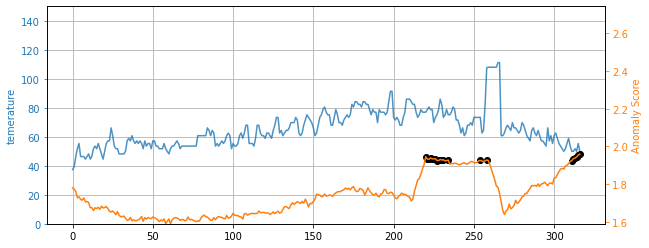

In [82]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 0, len(skajit_window)
skajit_data_subset = skajit_window[start:end]

ax1.plot(skajit_window, color='C0', alpha=0.8)
ax2.plot(scores, color='C1')
ax2.scatter(anomaly_indices, anomalies, color='k')

ax1.grid(which='major', axis='both')
ax1.set_ylabel('temerature', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')
ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')
ax1.set_ylim(0, 150)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

## now streaming case
this is simulated.  we send the servive a window of 25 shingles to do the inference for each time step in the interesting range.

In [92]:
anoms= []
for base in range(100,300):
    results = rcf_inference.predict(skajit_data_shingled[base:base+25])
    scores = np.array([datum['score'] for datum in results['scores']])

    # compute the shingled score distribution and cutoff and determine anomalous scores
    score_mean = scores.mean()
    score_std = scores.std()
    score_cutoff = score_mean +2.4*score_std

    anomalies = scores[scores > score_cutoff]
    anomaly_indices = np.arange(len(scores))[scores > score_cutoff]

    #print(anomalies)
    #print(anomaly_indices+base+10)
    anoms.append(anomaly_indices+base)                                                    
                                                       

In [93]:
xl = []
for x in anoms:
    xl = xl+x.tolist()
s = set(xl)
xl = list(s)
anomalies = []
for x in xl:
    anomalies.append(2.0)

In [94]:
xl.sort()

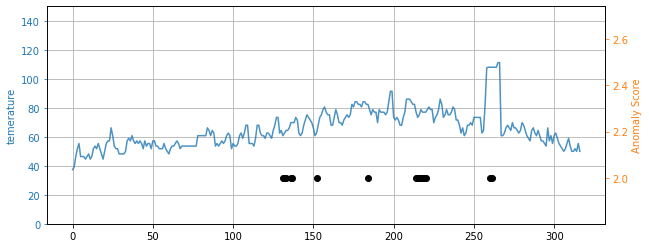

In [95]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
anomaly_indices = xl
#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 0, len(skajit_window)
skajit_data_subset = skajit_window[start:end]

ax1.plot(skajit_window, color='C0', alpha=0.8)
#ax2.plot(scores, color='C1')
ax2.scatter(anomaly_indices, anomalies, color='k')

ax1.grid(which='major', axis='both')
ax1.set_ylabel('temerature', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')
ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')
ax1.set_ylim(0, 150)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

In [96]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

### now for fake case.
this is the sine wave with a few spikes.

In [9]:
import numpy as np

In [11]:
pi = 3.14
fakedata = np.zeros(500)
for i in range(len(fakedata)):
    fakedata[i] = 0.5*np.sin(pi*i/10)+4.0
    pi = 0.9995*pi
fakedata[120] =3
fakedata[300] =5 
fakedata[121] =5
fakedata[301] =2

In [17]:
# single data with shingle size=48 (one day)
shingle_size = 48
prefix_shingled = 'sagemaker/randomcutforest_shingled'
fake_data_shingled = shingle(fakedata, shingle_size)
print(fake_data_shingled)

[[4.         4.1543581  4.29350968 ... 4.47436234 4.49988262 4.48080604]
 [4.1543581  4.29350968 4.40395229 ... 4.49988262 4.48080604 4.41896337]
 [4.29350968 4.40395229 4.47503964 ... 4.48080604 4.41896337 4.31997455]
 ...
 [3.77456149 3.86502435 3.96046141 ... 4.489159   4.46184794 4.41890841]
 [3.86502435 3.96046141 4.0572742  ... 4.46184794 4.41890841 4.36184736]
 [3.96046141 4.0572742  4.1518332  ... 4.41890841 4.36184736 4.29263976]]


In [18]:
session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix_shingled),
                      output_path='s3://{}/{}/output'.format(bucket, prefix_shingled),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(fake_data_shingled))

2020-03-11 18:02:30 Starting - Starting the training job...
2020-03-11 18:02:31 Starting - Launching requested ML instances...
2020-03-11 18:03:29 Starting - Preparing the instances for training......
2020-03-11 18:04:26 Downloading - Downloading input data...
2020-03-11 18:04:56 Training - Downloading the training image..Docker entrypoint called with argument(s): train
/opt/amazon/lib/python2.7/site-packages/scipy/_lib/_numpy_compat.py:10: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing.nosetester import import_nose
/opt/amazon/lib/python2.7/site-packages/scipy/stats/morestats.py:12: DeprecationWarning: Importing from numpy.testing.decorators is deprecated, import from numpy.testing instead.
  from numpy.testing.decorators import setastest
[03/11/2020 18:05:19 INFO 139939851147072] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_p

In [19]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'appliation/json'
rcf_inference.deserializer = json_deserializer

---------------!

In [21]:
anoms= []
for base in range(50, 400):
    results = rcf_inference.predict(fake_data_shingled[base:base+25])
    scores = np.array([datum['score'] for datum in results['scores']])

    # compute the shingled score distribution and cutoff and determine anomalous scores
    score_mean = scores.mean()
    score_std = scores.std()
    score_cutoff = score_mean +2.3*score_std

    anomalies = scores[scores > score_cutoff]
    anomaly_indices = np.arange(len(scores))[scores > score_cutoff]

    #print(anomalies)
    #print(anomaly_indices+base+10)
    anoms.append(anomaly_indices+base)                                                    
                                            

[1.53054721]
[84]
[1.53054721 1.53381845]
[84 85]
[1.53934995]
[86]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1.57845245]
[124]
[]
[]
[]
[]
[]
[]
[]
[]
[1.53042645]
[130]
[1.53042645]
[130]
[1.50431055]
[131]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

In [22]:
xl = []
for x in anoms:
    xl = xl+x.tolist()
s = set(xl)
xl = list(s)
anomalies = []
for x in xl:
    anomalies.append(2.0)
xl.sort()

In [28]:
len(fake_data_shingled)
fake_window = fake_data_shingled[:, 0]

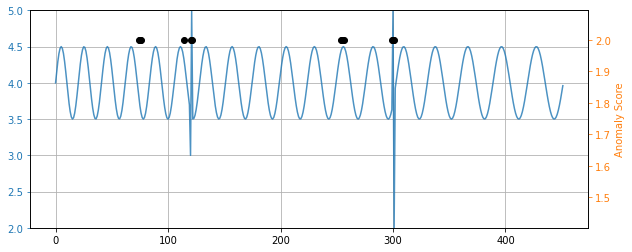

In [34]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
anomaly_indices = xl
#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 0, len(fake_window)
fake_data_subset = fake_window[start:end]

ax1.plot(fake_window, color='C0', alpha=0.8)
#ax2.plot(scores, color='C1')
ax2.scatter(anomaly_indices, anomalies, color='k')

ax1.grid(which='major', axis='both')
#ax1.set_ylabel('temerature', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')
ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')
ax1.set_ylim(2, 5)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

In [35]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)